## Import Libraries

In [31]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Verify GPU
cuda.init()
print(f"GPU: {cuda.Device(0).name()}")

GPU: NVIDIA GeForce RTX 2060


## Define CUDA Kernels

In [9]:
matrix_mult_kernel = """
__global__ void matrix_mult(float *a, float *b, float *c, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += a[row * N + k] * b[k * N + col];
        }
        c[row * N + col] = sum;
    }
}
"""

matrix_add_kernel = """
__global__ void matrix_add(float *a, float *b, float *result, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        result[row * N + col] = a[row * N + col] + b[row * N + col];
    }
}
"""

## Compile Kernels

In [10]:
# Compile the CUDA kernels
mod_mult = SourceModule(matrix_mult_kernel)
mod_add = SourceModule(matrix_add_kernel)

# Get the kernel functions
matrix_mult = mod_mult.get_function("matrix_mult")
matrix_add = mod_add.get_function("matrix_add")

## Define CPU/GPU Functions

In [11]:
def cpu_operation(A, B, C):
    """Perform A × B × C + A on CPU"""
    temp = np.dot(A, B)
    temp = np.dot(temp, C)
    return temp + A

def gpu_operation(A, B, C):
    """Perform A × B × C + A on GPU"""
    N = A.shape[0]

    # Allocate GPU memory
    A_gpu = cuda.mem_alloc(A.nbytes)
    B_gpu = cuda.mem_alloc(B.nbytes)
    C_gpu = cuda.mem_alloc(C.nbytes)
    temp1_gpu = cuda.mem_alloc(A.nbytes)
    temp2_gpu = cuda.mem_alloc(A.nbytes)
    result_gpu = cuda.mem_alloc(A.nbytes)

    # Copy matrices to GPU
    cuda.memcpy_htod(A_gpu, A)
    cuda.memcpy_htod(B_gpu, B)
    cuda.memcpy_htod(C_gpu, C)

    # Define block and grid dimensions
    block_size = 16
    block = (block_size, block_size, 1)
    grid = (int((N + block_size - 1) / block_size), int((N + block_size - 1) / block_size))

    # First multiplication: A × B -> temp1
    matrix_mult(A_gpu, B_gpu, temp1_gpu, np.int32(N), block=block, grid=grid)

    # Second multiplication: temp1 × C -> temp2
    matrix_mult(temp1_gpu, C_gpu, temp2_gpu, np.int32(N), block=block, grid=grid)

    # Addition: temp2 + A -> result
    matrix_add(temp2_gpu, A_gpu, result_gpu, np.int32(N), block=block, grid=grid)

    # Copy result back to host
    result = np.empty_like(A)
    cuda.memcpy_dtoh(result, result_gpu)

    # Free GPU memory
    A_gpu.free()
    B_gpu.free()
    C_gpu.free()
    temp1_gpu.free()
    temp2_gpu.free()
    result_gpu.free()

    return result

## Performance Testing & Plotting

In [12]:
def test_performance(matrix_sizes):
    """Test performance for different matrix sizes"""
    cpu_times = []
    gpu_times = []

    for size in matrix_sizes:
        print(f"Testing size: {size}x{size}")

        # Generate random matrices
        A = np.random.rand(size, size).astype(np.float32)
        B = np.random.rand(size, size).astype(np.float32)
        C = np.random.rand(size, size).astype(np.float32)

        # CPU operation
        start = time.time()
        cpu_result = cpu_operation(A, B, C)
        cpu_time = time.time() - start
        cpu_times.append(cpu_time)

        # GPU operation
        start = time.time()
        gpu_result = gpu_operation(A, B, C)
        gpu_time = time.time() - start
        gpu_times.append(gpu_time)

        # Verify results (should be very close)
        if not np.allclose(cpu_result, gpu_result, atol=1e-4):
            print("Warning: CPU and GPU results don't match for size", size)

    return cpu_times, gpu_times

def plot_results(matrix_sizes, cpu_times, gpu_times):
    """Plot the performance results and speedup in separate figures"""
    # Calculate speedup factors
    speedup = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times)]

    # Figure 1: Execution Times
    plt.figure(figsize=(8, 6))
    plt.plot(matrix_sizes, cpu_times, 'b-o', label='CPU')
    plt.plot(matrix_sizes, gpu_times, 'r-o', label='GPU')
    plt.xlabel('Matrix Size (NxN)')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison: CPU vs GPU')
    plt.legend()
    plt.grid(True)
    plt.savefig('execution_times.png')
    plt.show()

    # Figure 2: Speedup Factor
    plt.figure(figsize=(8, 6))
    plt.plot(matrix_sizes, speedup, 'g-s', linewidth=2, markersize=8, label='Speedup')
    plt.xlabel('Matrix Size (NxN)')
    plt.ylabel('Speedup Factor (CPU Time/GPU Time)')
    plt.title('GPU Speedup Over CPU')
    plt.axhline(y=1, color='k', linestyle='--', label='No Speedup')

    # Annotate each speedup point with its value
    for i, txt in enumerate(speedup):
        plt.annotate(f"{txt:.1f}x", (matrix_sizes[i], speedup[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.grid(True)
    plt.savefig('speedup_factor.png')
    plt.show()

## Main

Running performance tests...
Testing size: 64x64
Testing size: 128x128
Testing size: 256x256
Testing size: 512x512
Testing size: 1024x1024

Results:
Size 64x64: CPU=0.0002s, GPU=0.0009s, Speedup=0.18x
Size 128x128: CPU=0.0002s, GPU=0.0006s, Speedup=0.36x
Size 256x256: CPU=0.0011s, GPU=0.0012s, Speedup=0.91x
Size 512x512: CPU=0.0069s, GPU=0.0042s, Speedup=1.64x
Size 1024x1024: CPU=0.0506s, GPU=0.0242s, Speedup=2.09x


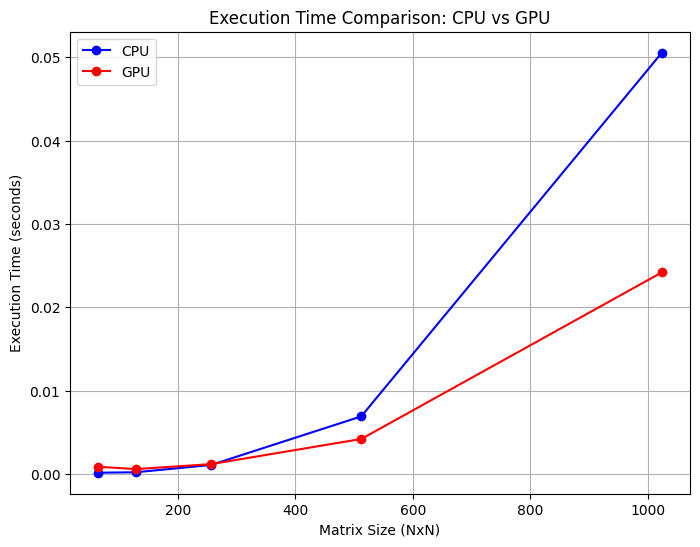

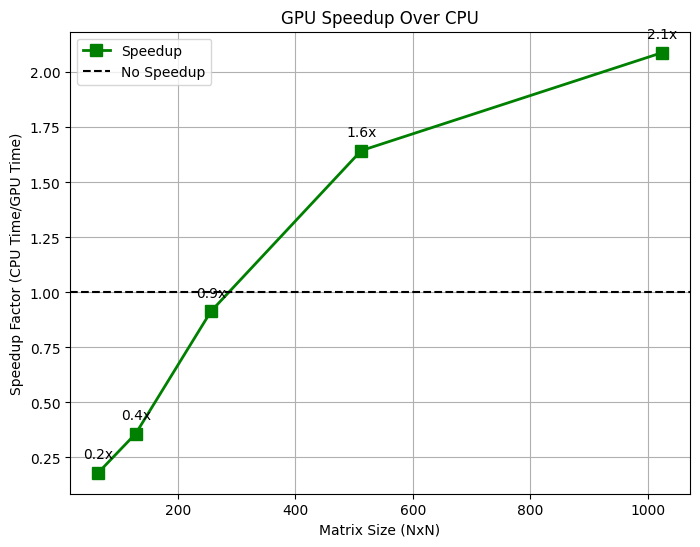

In [15]:
if __name__ == "__main__":
    # Test different matrix sizes
    matrix_sizes = [64, 128, 256, 512, 1024]

    print("Running performance tests...")
    cpu_times, gpu_times = test_performance(matrix_sizes)

    print("\nResults:")
    for size, cpu, gpu in zip(matrix_sizes, cpu_times, gpu_times):
        print(f"Size {size}x{size}: CPU={cpu:.4f}s, GPU={gpu:.4f}s, Speedup={cpu/gpu:.2f}x")

    # Plot the results
    plot_results(matrix_sizes, cpu_times, gpu_times)